## Summary

We will use [Ames Housing](http://jse.amstat.org/v19n3/decock.pdf) dataset which was first compiled by Dean De Cock and became better known after it was used in Kaggle challenge. It is a set of 1460 residential homes in Ames, Iowa, each described by 80 features. We will use it to predict the final logarithmic price of the houses. In this example we will use only 20 most interesting features.

In [1]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_california_housing, fetch_openml, load_boston
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             max_error,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

set_config(display="diagram", print_changed_only=False)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
def load_ames_housing():
    dframe = fetch_openml(name="house_prices", as_frame=True)
    X = dframe.data
    y = dframe.target
    
    print(f"Shape of raw input features: {X.shape}")
    print(f"Shape of target feature : {y.shape}")
    print("\nSample - first rows")
    display(X.head())
    # select most interesting features
    features = [
        "YrSold",
        "HeatingQC",
        "Street",
        "YearRemodAdd",
        "Heating",
        "MasVnrType",
        "BsmtUnfSF",
        "Foundation",
        "MasVnrArea",
        "LotArea",
        "MSSubClass",
        "ExterQual",
        "Condition2",
        "GarageCars",
        "GarageType",
        "OverallQual",
        "TotalBsmtSF",
        "BsmtFinSF1",
        "HouseStyle",
        "MiscFeature",
        "MoSold",
    ]
    X = X[features]
    print(f"\nFull description of the dataset\n\n{dframe.DESCR}")
    return X, y



In [3]:
X, y = load_ames_housing()

Shape of raw input features: (1460, 80)
Shape of target feature : (1460,)

Sample - first rows


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal



Full description of the dataset

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY 

In [4]:
X.head()

,YrSold,HeatingQC,Street,YearRemodAdd,Heating,MasVnrType,BsmtUnfSF,Foundation,MasVnrArea,LotArea,MSSubClass,ExterQual,Condition2,GarageCars,GarageType,OverallQual,TotalBsmtSF,BsmtFinSF1,HouseStyle,MiscFeature,MoSold
0,2008.0,Ex,Pave,2003.0,GasA,BrkFace,150.0,PConc,196.0,8450.0,60.0,Gd,Norm,2.0,Attchd,7.0,856.0,706.0,2Story,None,2.0
1,2007.0,Ex,Pave,1976.0,GasA,None,284.0,CBlock,0.0,9600.0,20.0,TA,Norm,2.0,Attchd,6.0,1262.0,978.0,1Story,None,5.0
2,2008.0,Ex,Pave,2002.0,GasA,BrkFace,434.0,PConc,162.0,11250.0,60.0,Gd,Norm,2.0,Attchd,7.0,920.0,486.0,2Story,None,9.0
3,2006.0,Gd,Pave,1970.0,GasA,None,540.0,BrkTil,0.0,9550.0,70.0,TA,Norm,3.0,Detchd,7.0,756.0,216.0,2Story,None,2.0
4,2008.0,Ex,Pave,2000.0,GasA,BrkFace,490.0,PConc,350.0,14260.0,60.0,Gd,Norm,3.0,Attchd,8.0,1145.0,655.0,2Story,None,12.0


In [5]:
X.describe(include="all")

,YrSold,HeatingQC,Street,YearRemodAdd,Heating,MasVnrType,BsmtUnfSF,Foundation,MasVnrArea,LotArea,MSSubClass,ExterQual,Condition2,GarageCars,GarageType,OverallQual,TotalBsmtSF,BsmtFinSF1,HouseStyle,MiscFeature,MoSold
count,1460.000000,1460,1460,1460.000000,1460,1452,1460.000000,1460,1452.000000,1460.000000,1460.000000,1460,1460,1460.000000,1379,1460.000000,1460.000000,1460.000000,1460,54,1460.000000
unique,NaN,5,2,NaN,6,4,NaN,6,NaN,NaN,NaN,4,8,NaN,6,NaN,NaN,NaN,8,4,NaN
top,NaN,Ex,Pave,NaN,GasA,None,NaN,PConc,NaN,NaN,NaN,TA,Norm,NaN,Attchd,NaN,NaN,NaN,1Story,Shed,NaN
freq,NaN,741,1454,NaN,1428,864,NaN,647,NaN,NaN,NaN,906,1445,NaN,870,NaN,NaN,NaN,726,49,NaN
mean,2007.815753,NaN,NaN,1984.865753,NaN,NaN,567.240411,NaN,103.685262,10516.828082,56.897260,NaN,NaN,1.767123,NaN,6.099315,1057.429452,443.639726,NaN,NaN,6.321918
std,1.328095,NaN,NaN,20.645407,NaN,NaN,441.866955,NaN,181.066207,9981.264932,42.300571,NaN,NaN,0.747315,NaN,1.382997,438.705324,456.098091,NaN,NaN,2.703626
min,2006.000000,NaN,NaN,1950.000000,NaN,NaN,0.000000,NaN,0.000000,1300.000000,20.000000,NaN,NaN,0.000000,NaN,1.000000,0.000000,0.000000,NaN,NaN,1.000000
25%,2007.000000,NaN,NaN,1967.000000,NaN,NaN,223.000000,NaN,0.000000,7553.500000,20.000000,NaN,NaN,1.000000,NaN,5.000000,795.750000,0.000000,NaN,NaN,5.000000
50%,2008.000000,NaN,NaN,1994.000000,NaN,NaN,477.500000,NaN,0.000000,9478.500000,50.000000,NaN,NaN,2.000000,NaN,6.000000,991.500000,383.500000,NaN,NaN,6.000000
75%,2009.000000,NaN,NaN,2004.000000,NaN,NaN,808.000000,NaN,166.000000,11601.500000,70.000000,NaN,NaN,2.000000,NaN,7.000000,1298.250000,712.250000,NaN,NaN,8.000000


## EDA: Exploratory Data Analysis

In [6]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

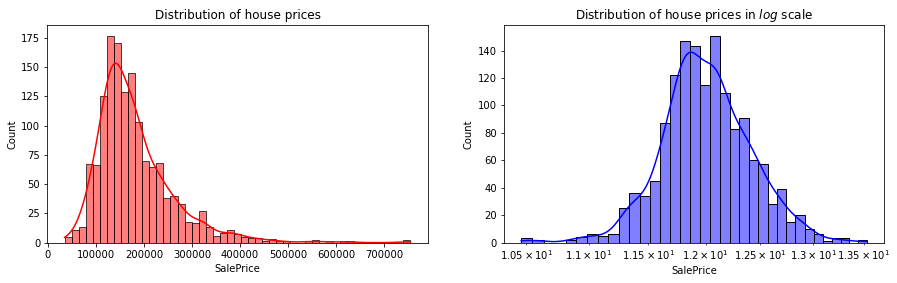

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.histplot(y, color='r', kde=True, ax=axes[0])
axes[0].set_title('Distribution of house prices')

log_y = np.log(y)
sns.histplot(log_y, color='b', kde=True, ax=axes[1])
axes[1].set_title('Distribution of house prices in $log$ scale')
axes[1].set_xscale('log');

If we look at the left plot the sale house price varies from 34900 to 755000, the plot is right skewed. In right plot we will apply natural log, then plot approximately tends to normal. for further analysis we will apply log on target variable charges.Normality is an important assumption for many statistical techniques

- `log`is a particular transformation of Box-Cox
- [Box-Cox transformation](https://www.statisticshowto.com/box-cox-transformation/): A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape.

```from scipy.stats import boxcox
y_bc,lam, ci= boxcox(y,alpha=0.05)```

In [8]:
categorical_features = X.select_dtypes(include="object").columns
print(f"Categorical features:\n {categorical_features}\n")

numerical_features = X.select_dtypes(include="number").columns
print(f"Numerical features:\n {numerical_features}")

Categorical features:
 Index(['HeatingQC', 'Street', 'Heating', 'MasVnrType', 'Foundation',
       'ExterQual', 'Condition2', 'GarageType', 'HouseStyle', 'MiscFeature'],
      dtype='object')

Numerical features:
 Index(['YrSold', 'YearRemodAdd', 'BsmtUnfSF', 'MasVnrArea', 'LotArea',
       'MSSubClass', 'GarageCars', 'OverallQual', 'TotalBsmtSF', 'BsmtFinSF1',
       'MoSold'],
      dtype='object')


In [9]:
feature_names = X.columns

In [10]:
len(feature_names)

21

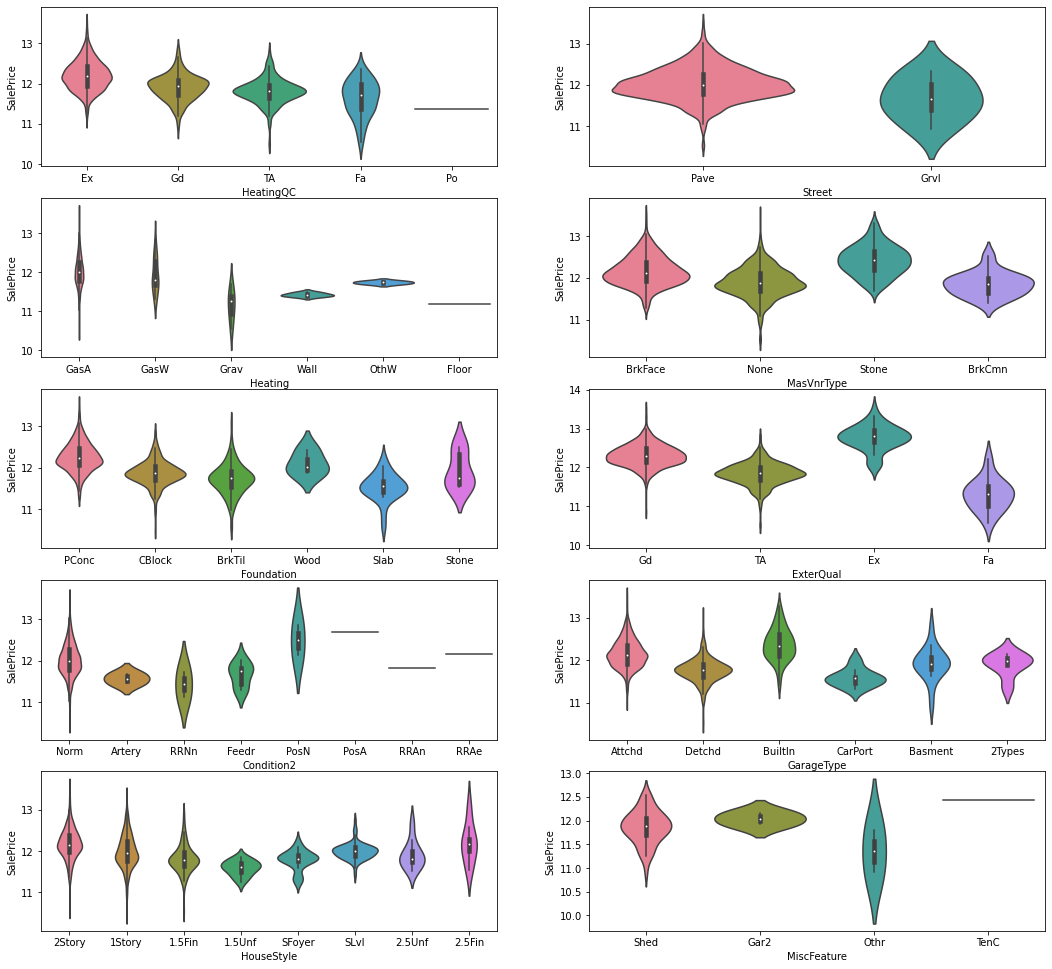

In [11]:
ncols = 2  # number of columns in subplot
nrows = sum(divmod(len(categorical_features), ncols))  # number of rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 17))
axes = axes.ravel()

for i, col_name in enumerate(categorical_features):
    ax = axes[i]
    sns.violinplot(x=col_name, y=log_y, data=X, palette='husl', ax=ax)


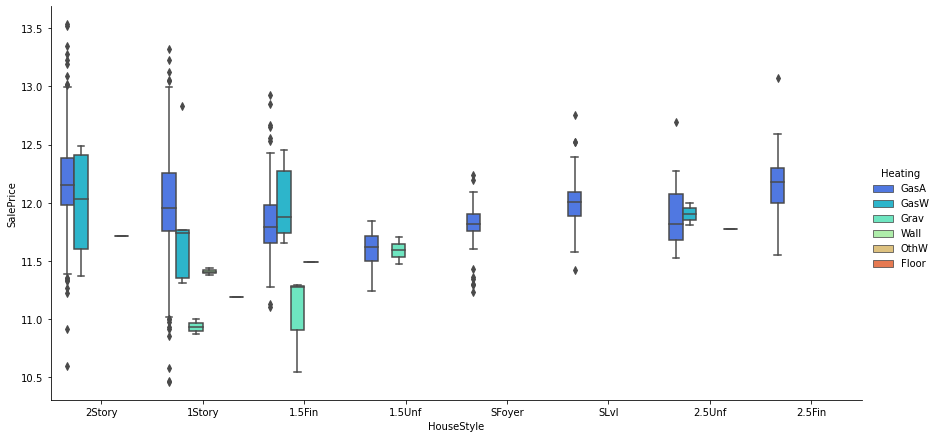

In [12]:
sns.catplot(kind="box", x='HouseStyle', y=log_y, hue='Heating',
            data=X, palette='rainbow', height=6, aspect=2);

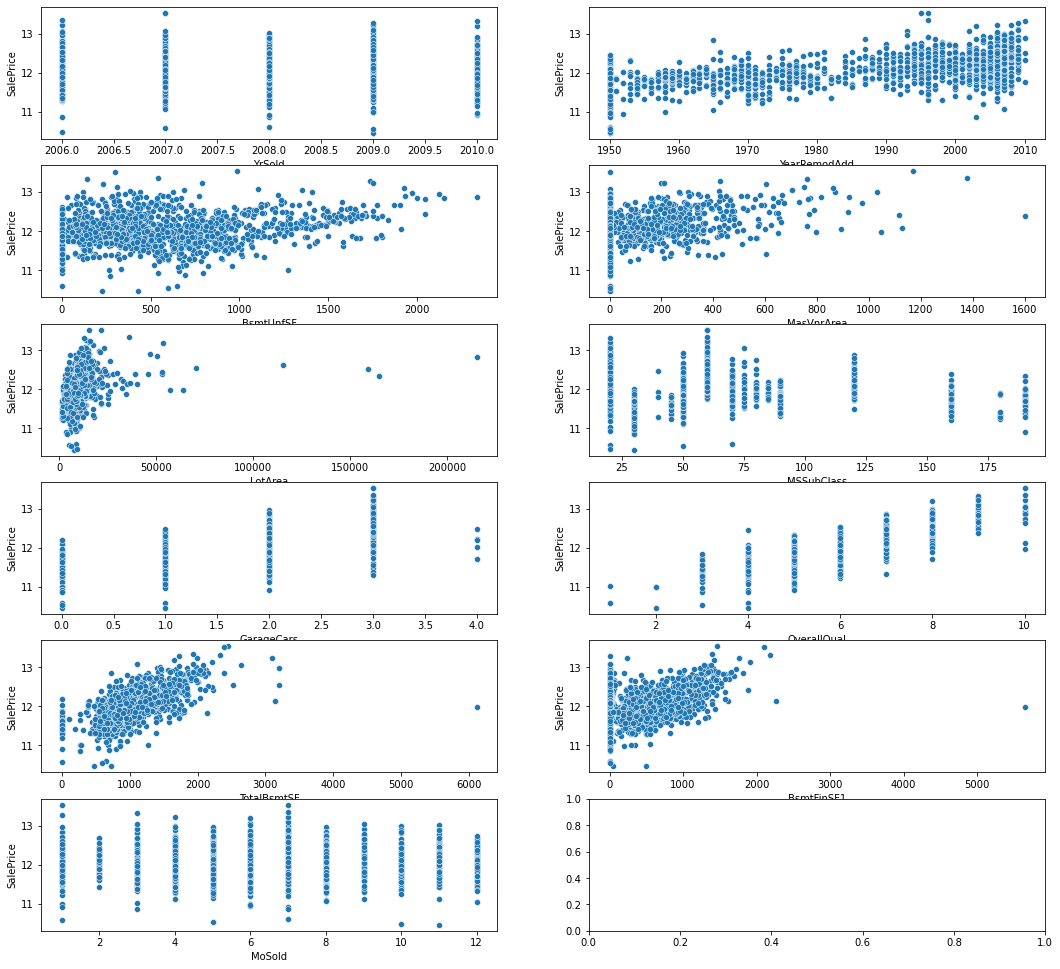

In [13]:
nrows = sum(divmod(len(numerical_features), ncols))  # number of rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 17))
axes = axes.ravel()

for i, col_name in enumerate(numerical_features):
    sns.scatterplot(x=col_name, y=log_y, data=X, ax=axes[i])

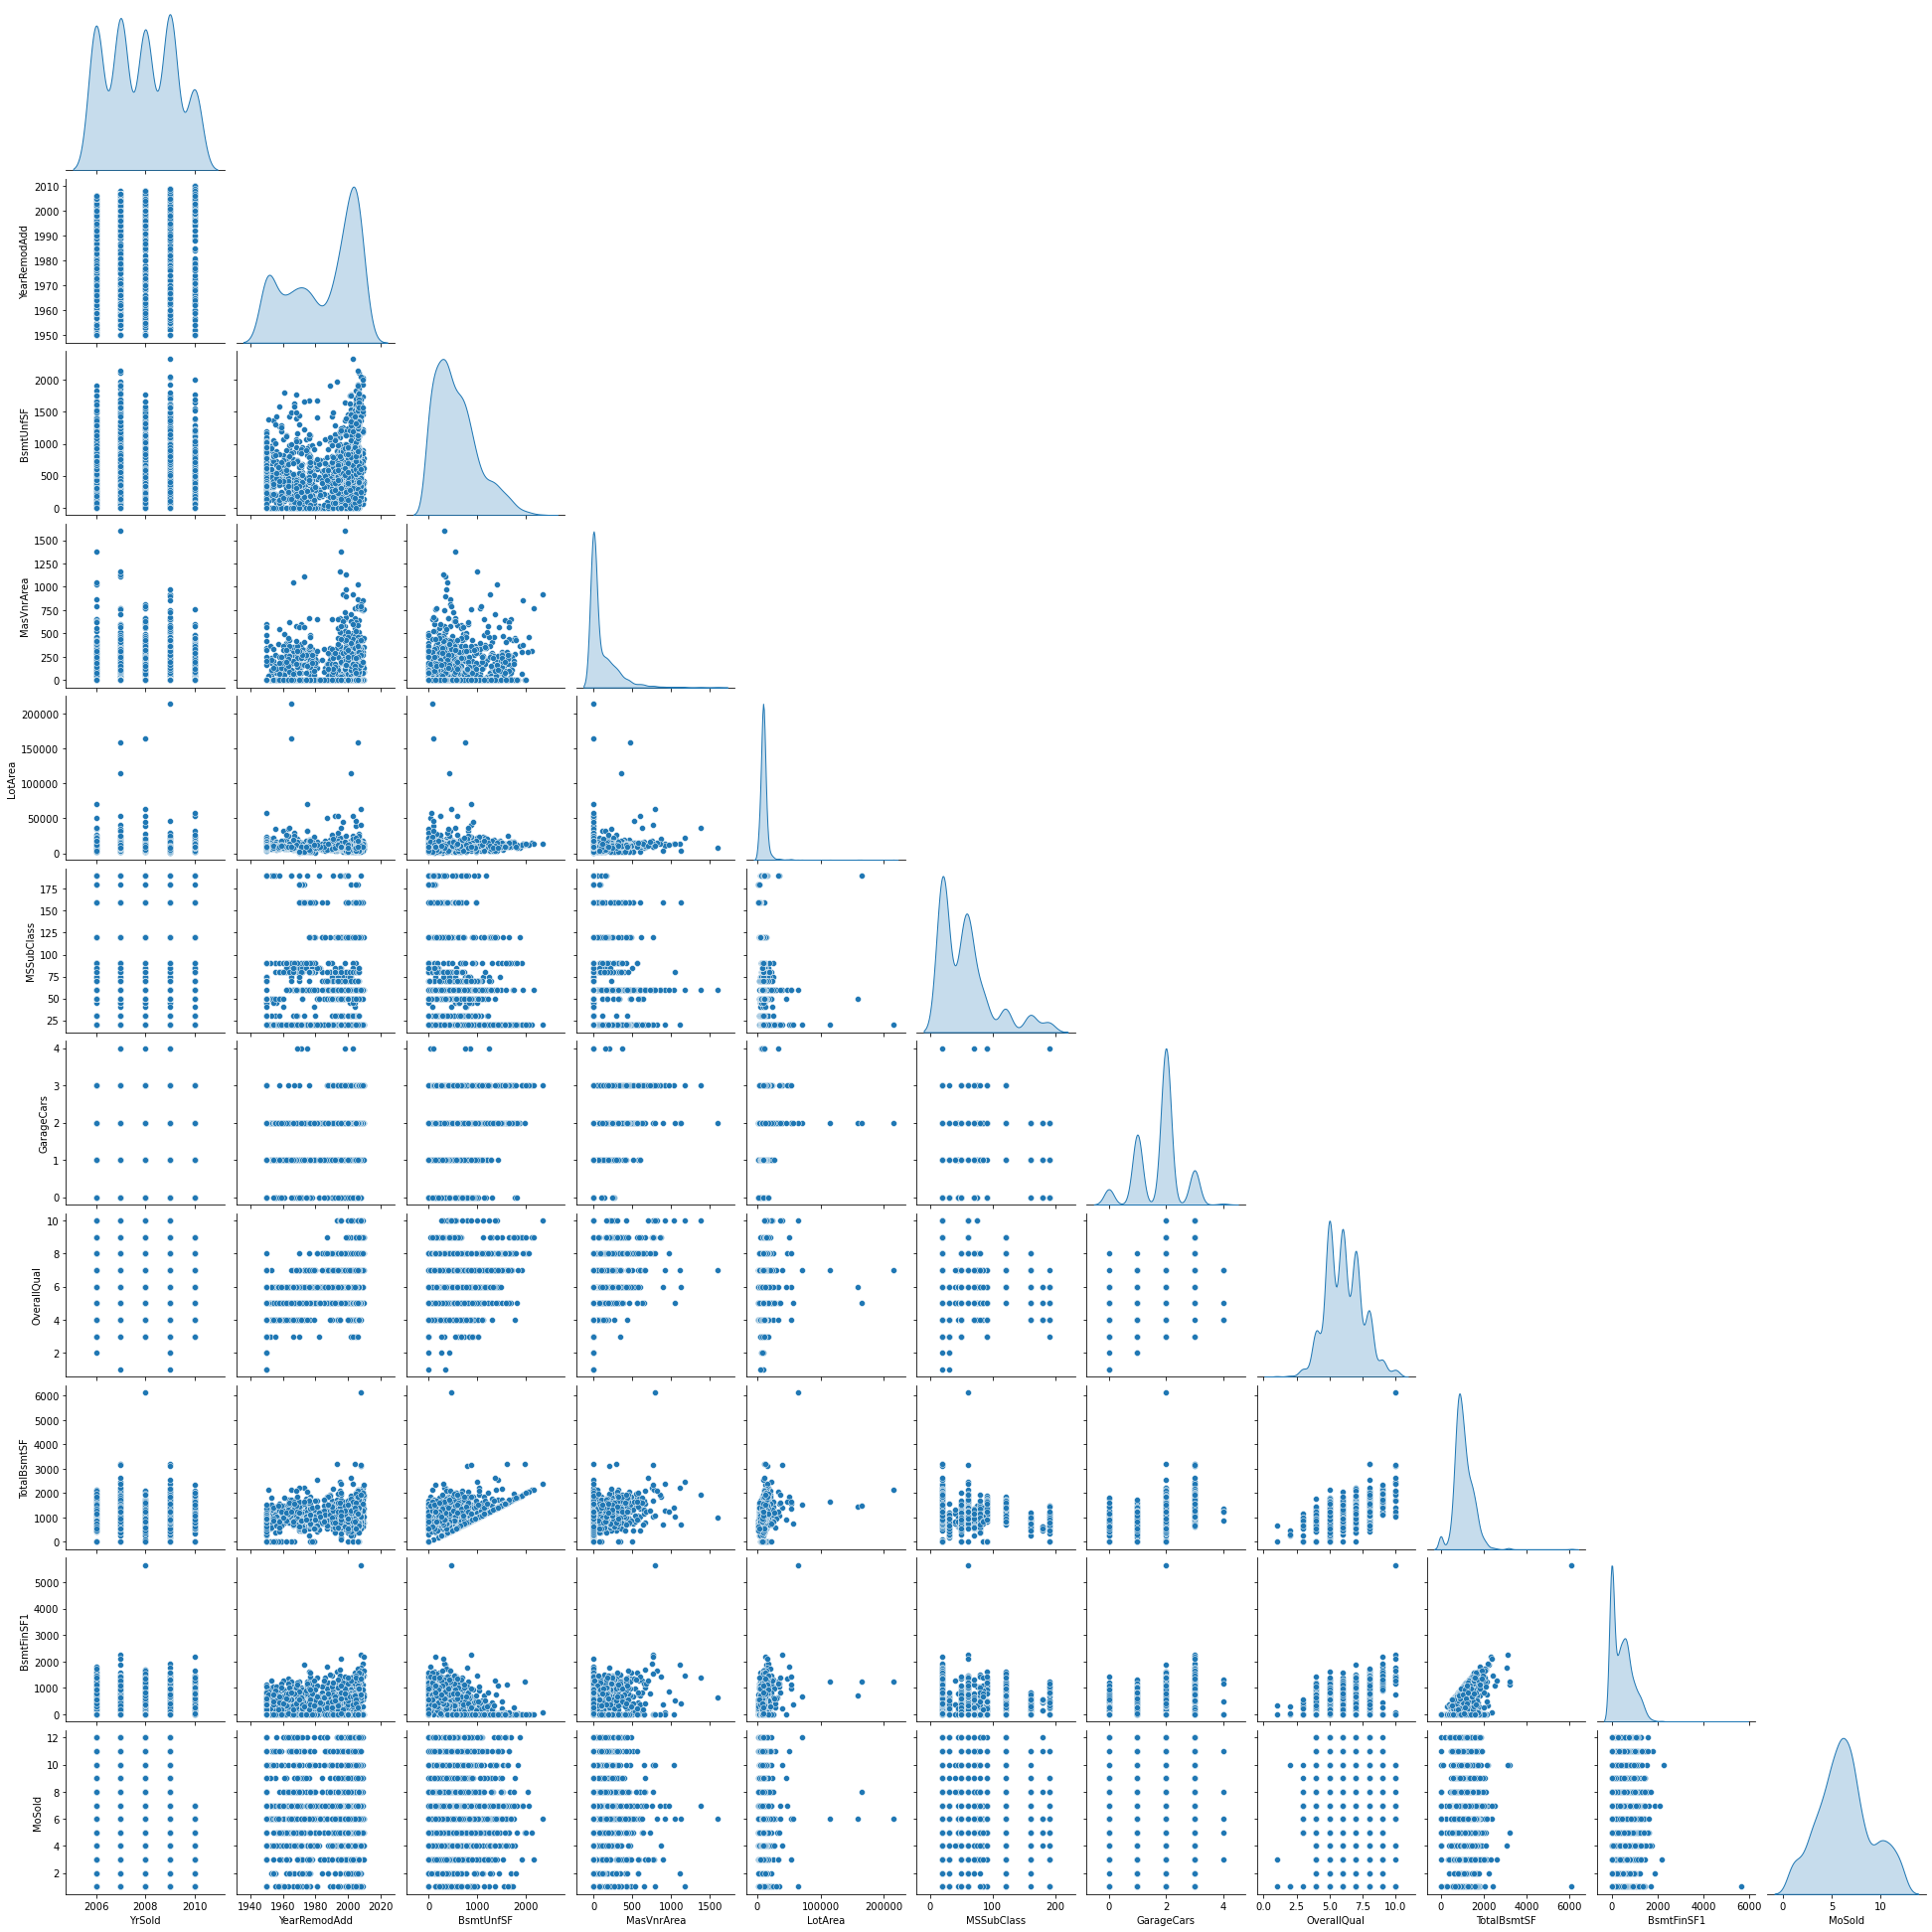

In [14]:
## pair plot
sns.pairplot(X, corner=True, diag_kind="kde");

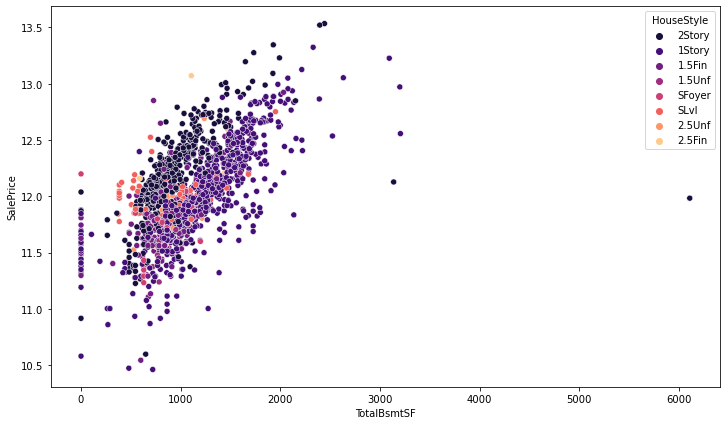

In [15]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='TotalBsmtSF', y=log_y, data=X, palette='magma', hue='HouseStyle',);

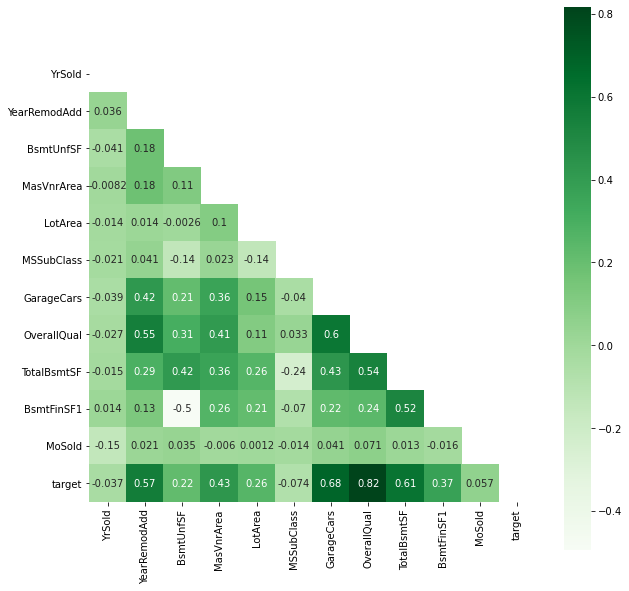

In [16]:
# correlation plot
plt.figure(figsize=(10, 10))
corr = X.assign(target=log_y).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, cmap='Greens', annot=True, square=True, mask=mask);

### Data Preprocessing
Encoding
Machine learning algorithms cannot work with categorical data directly, categorical data must be converted to number.

    1- Label Encoding
    2- One hot encoding
    3- Dummy variable trap
    
**Label encoding** refers to transforming the word labels into numerical form so that the algorithms can understand how to operate on them.

A **One hot encoding** is a representation of categorical variable as binary vectors.It allows the representation of categorical data to be more expresive. This first requires that the categorical values be mapped to integer values, that is label encoding. Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.

The **Dummy variable** trap is a scenario in which the independent variable are multicollinear, a scenario in which two or more variables are highly correlated in simple term one variable can be predicted from the others.

By using pandas get_dummies function we can do all above three step in line of code. We will this fuction to get dummy variable for sex, children,smoker,region features. By setting drop_first =True function will remove dummy variable trap by droping one variable and original variable.The pandas makes our life easy.

In [17]:
X_encode = pd.get_dummies(data=X, prefix='OHE', prefix_sep='_',
                           columns=categorical_features,
                           drop_first=True,
                           dtype='int8')
X_encode

,YrSold,YearRemodAdd,BsmtUnfSF,MasVnrArea,LotArea,MSSubClass,GarageCars,OverallQual,TotalBsmtSF,BsmtFinSF1,MoSold,OHE_Fa,OHE_Gd,OHE_Po,OHE_TA,OHE_Pave,OHE_GasA,OHE_GasW,OHE_Grav,OHE_OthW,OHE_Wall,OHE_BrkFace,OHE_None,OHE_Stone,OHE_CBlock,OHE_PConc,OHE_Slab,OHE_Stone,OHE_Wood,OHE_Fa,OHE_Gd,OHE_TA,OHE_Feedr,OHE_Norm,OHE_PosA,OHE_PosN,OHE_RRAe,OHE_RRAn,OHE_RRNn,OHE_Attchd,OHE_Basment,OHE_BuiltIn,OHE_CarPort,OHE_Detchd,OHE_1.5Unf,OHE_1Story,OHE_2.5Fin,OHE_2.5Unf,OHE_2Story,OHE_SFoyer,OHE_SLvl,OHE_Othr,OHE_Shed,OHE_TenC
0,2008.0,2003.0,150.0,196.0,8450.0,60.0,2.0,7.0,856.0,706.0,2.0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2007.0,1976.0,284.0,0.0,9600.0,20.0,2.0,6.0,1262.0,978.0,5.0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2008.0,2002.0,434.0,162.0,11250.0,60.0,2.0,7.0,920.0,486.0,9.0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,2006.0,1970.0,540.0,0.0,9550.0,70.0,3.0,7.0,756.0,216.0,2.0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,2008.0,2000.0,490.0,350.0,14260.0,60.0,3.0,8.0,1145.0,655.0,12.0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2007.0,2000.0,953.0,0.0,7917.0,60.0,2.0,6.0,953.0,0.0,8.0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1456,2010.0,1988.0,589.0,119.0,13175.0,20.0,2.0,6.0,1542.0,790.0,2.0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1457,2010.0,2006.0,877.0,0.0,9042.0,70.0,1.0,7.0,1152.0,275.0,5.0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1458,2010.0,1996.0,0.0,0.0,9717.0,20.0,1.0,5.0,1078.0,49.0,4.0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [18]:
# Lets verify the dummy variable process
print('Columns in original data frame:\n', X.columns)
print('\nColumns in data frame after encoding dummy variable:\n', X_encode.columns)
print('\nNumber of rows and columns in the dataset:', X_encode.shape)

Columns in original data frame:
 Index(['YrSold', 'HeatingQC', 'Street', 'YearRemodAdd', 'Heating',
       'MasVnrType', 'BsmtUnfSF', 'Foundation', 'MasVnrArea', 'LotArea',
       'MSSubClass', 'ExterQual', 'Condition2', 'GarageCars', 'GarageType',
       'OverallQual', 'TotalBsmtSF', 'BsmtFinSF1', 'HouseStyle', 'MiscFeature',
       'MoSold'],
      dtype='object')

Columns in data frame after encoding dummy variable:
 Index(['YrSold', 'YearRemodAdd', 'BsmtUnfSF', 'MasVnrArea', 'LotArea',
       'MSSubClass', 'GarageCars', 'OverallQual', 'TotalBsmtSF', 'BsmtFinSF1',
       'MoSold', 'OHE_Fa', 'OHE_Gd', 'OHE_Po', 'OHE_TA', 'OHE_Pave',
       'OHE_GasA', 'OHE_GasW', 'OHE_Grav', 'OHE_OthW', 'OHE_Wall',
       'OHE_BrkFace', 'OHE_None', 'OHE_Stone', 'OHE_CBlock', 'OHE_PConc',
       'OHE_Slab', 'OHE_Stone', 'OHE_Wood', 'OHE_Fa', 'OHE_Gd', 'OHE_TA',
       'OHE_Feedr', 'OHE_Norm', 'OHE_PosA', 'OHE_PosN', 'OHE_RRAe', 'OHE_RRAn',
       'OHE_RRNn', 'OHE_Attchd', 'OHE_Basment', 'OHE_BuiltIn',

In [19]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                                      ("scaler", StandardScaler())]
                              )

categorical_transformer = make_pipeline(*[SimpleImputer(strategy="constant", fill_value="missing"),
                                          OneHotEncoder(handle_unknown="ignore")]
                                       )


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Append regressor to preprocessing pipeline.
# Now we have a full prediction pipeline.
reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)
reg

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose=0)),
                                                                  ('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean...
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse=True))],
                                                           verbose=False),
                                                  Index(['HeatingQC', 'Street', 'Heating', 'MasVnrType', 'Foundation',
       'ExterQual', 'Condition2', 'GarageType', 'HouseStyle', 'MiscFeature'],
      dtype='object'))],
                                   verbose=False)),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False, positive=False))],
         verbose=False)

## Modeling

### Train/test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, log_y, test_size=0.25, random_state=23)

### Linear regression

In [21]:
reg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose=0)),
                                                                  ('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean...
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse=True))],
                                                           verbose=False),
                                                  Index(['HeatingQC', 'Street', 'Heating', 'MasVnrType', 'Foundation',
       'ExterQual', 'Condition2', 'GarageType', 'HouseStyle', 'MiscFeature'],
      dtype='object'))],
                                   verbose=False)),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False, positive=False))],
         verbose=False)

### Model evaluation

In [22]:
# sklearn regression module
y_test_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

In [23]:
def get_performances(real_value, estimated_value, metrics):
    perfs = []
    for metric_func in metrics:
        perfs.append((metric_func.__name__, metric_func(real_value, estimated_value)))
    return pd.DataFrame(perfs, columns=["metric", "value"])


def get_all_performances(value_train, values_test, metrics):
    test_perfs = []
    train_perfs = []
    metric_names = []
    for metric_func in metrics:
        metric_name = metric_func.__name__
        metric_names.append(metric_name)
        train_perfs.append(metric_func(*value_train))
        test_perfs.append(metric_func(*values_test))
    perfs = {"metric": metric_names, "train": train_perfs, "test": test_perfs,}
    return pd.DataFrame(perfs)

In [24]:
METRICS = [r2_score,
           mean_squared_error,
           mean_absolute_percentage_error,
           max_error,
          ]
# get performance on single set
get_performances(real_value=y_test, estimated_value=y_test_pred, metrics=METRICS)

,metric,value
0,r2_score,-3.965171e+20
1,mean_squared_error,6.151961e+19
2,mean_absolute_percentage_error,6.047715e+07
3,max_error,8.651524e+10


In [25]:
# get performances in train & test
get_all_performances(value_train=(y_train, y_train_pred),
                     values_test=(y_test, y_test_pred),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,0.827169,-3.965171e+20
1,mean_squared_error,0.027797,6.151961e+19
2,mean_absolute_percentage_error,0.009586,6.047715e+07
3,max_error,2.106548,8.651524e+10


### Model Validation
In order to validated model we need to check few assumption of linear regression model. The common assumption for Linear Regression model are following

- Linear Relationship: In linear regression the relationship between the dependent and independent variable to be linear. This - can be checked by scatter ploting Actual value Vs Predicted value
- The residual error plot should be normally distributed.
- The mean of residual error should be 0 or close to 0 as much as possible
- The linear regression require all variables to be multivariate normal. This assumption can best checked with Q-Q plot.
- Linear regession assumes that there is little or no Multicollinearity in the data. Multicollinearity occurs when the independent variables are too highly correlated with each other. The variance inflation factor VIF* identifies correlation between independent variables and strength of that correlation. [Math Processing Error], If VIF >1 & VIF <5 moderate correlation, VIF < 5 critical level of multicollinearity.
- Homoscedasticity: The data are homoscedastic meaning the residuals are equal across the regression line. We can look at residual Vs fitted value scatter plot. If heteroscedastic plot would exhibit a funnel shape pattern.

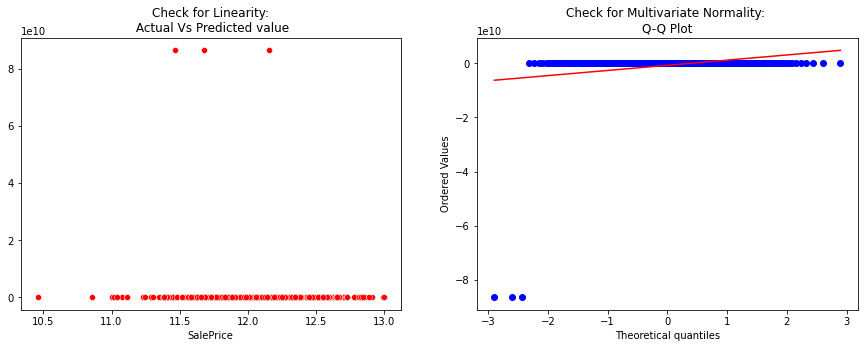

In [43]:
# Check for Linearity
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
g = sns.scatterplot(x=y_test, y=y_test_pred, ax=ax, color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = axes[1]
residus = y_test - y_test_pred
_, (_, _, r)= sp.stats.probplot(residus, fit=True,plot=ax)
ax.set_title('Check for Multivariate Normality: \nQ-Q Plot');

In [38]:
# Check for Multicollinearity
# Variance Inflation Factor (VIF)
R_square_test = mean_squared_error(y_test, y_test_pred, squared=True)
VIF = 1/(1- R_square_test)
VIF

-1.6254978339848563e-20

### Model Selection

In [ ]:
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "regressor__fit_intercept": [True, False],
}

grid_search = GridSearchCV(reg, param_grid, cv=10, scoring="r2", return_train_score=True) # r2
# you can see the list of key for scoring: sorted(sklearn.metrics.SCORERS.keys())
grid_search

In [ ]:
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best params: {best_params}")

In [ ]:
print(f"Internal CV score: {grid_search.best_score_:.3f}")

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results

In [ ]:
#cross validation only
cross_validate(reg,
               X_train, y_train,
               cv=3,
               scoring=('r2', 'neg_mean_squared_error'),
               return_train_score=True)

In [ ]:
cv_results[
    [
        "mean_test_score",
        "std_test_score",
        "mean_train_score",
        "std_train_score",
        "params"
,    ]
]

### Feature importances